## County Health Rankings

This data set is intended to demonstrate how various factors affect the health of counties in the United States, as well as highlight the dramatic range in health from county to county. These factors include access to affordable housing, access to well-paying jobs, education opportunities, and many others. This data is provided as a resource to help identify and address injustices and inequities in the health of counties in the United States.

The data set includes statistics on premature death rates, physical health, mental health, low birthweight, adult smoking, and countless others. The data is primarily numeric.

Documentation can be found at : https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2021.pdf


In [116]:
import pandas as pd
import requests
import io

from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from pylab import cm

import matplotlib.pyplot as plt
%matplotlib inline

#### Read in the data 

In [117]:
url = 'http://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2021.csv'
response = requests.get(url)

file_object = io.StringIO(response.content.decode('utf-8'))
df = pd.read_csv(file_object,skiprows=[0])

In [118]:
df.head()

,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,...,v057_rawvalue,v057_numerator,v057_denominator,v057_cilow,v057_cihigh,v058_rawvalue,v058_numerator,v058_denominator,v058_cilow,v058_cihigh
0,0,0,0,US,United States,2021,NaN,6906.641094,3854074.0,915437195.0,...,0.507502,166582199,328239523,NaN,NaN,0.192690,NaN,NaN,NaN,NaN
1,1,0,1000,AL,Alabama,2021,NaN,9819.887431,82249.0,13651801.0,...,0.516739,2533668,4903185,NaN,NaN,0.409632,1957932.0,4779736.0,NaN,NaN
2,1,1,1001,AL,Autauga County,2021,1.0,7830.053484,787.0,155765.0,...,0.515080,28777,55869,NaN,NaN,0.420022,22921.0,54571.0,NaN,NaN
3,1,3,1003,AL,Baldwin County,2021,1.0,7680.477270,3147.0,600539.0,...,0.515096,114987,223234,NaN,NaN,0.422791,77060.0,182265.0,NaN,NaN
4,1,5,1005,AL,Barbour County,2021,1.0,11476.629416,515.0,69011.0,...,0.470793,11622,24686,NaN,NaN,0.677896,18613.0,27457.0,NaN,NaN


There are USA aggregate data and state aggregate level data, let's focus only on counties

In [119]:
df = df[df['countycode']!=0]

There are 16 Maine counties that we will be taking a close look at later on 

In [120]:
maine_fipscode = df[(df['state']=='ME')].fipscode
maine_county_labels = [' Andr',' Aroo',' Cumb', ' Fran', ' Hanc',' Kenn', ' Knox', ' Linc', ' Oxfo', 
                       ' Peno', ' Pisc', ' Saga', ' Some', ' Waldo', ' Wash', ' York']

There are a lot of columns we do need. In particular the numerator, denominator, confidence interval, ... columns for forming the raw_values are included. We get rid of them 

In [121]:
# select all the columns from CHR with raw values
## these columns contain the major health-related variables
all_cols = df.columns
col_names = [i for i in all_cols if 'rawvalue' in i]
print ('Number of CHR variables: ',len(col_names))
## We include the fipscode column because we want to get only the maine counties out later on
col_names.insert(0,"fipscode") 
df_sub = df[col_names]
df_sub = df_sub.set_index('fipscode')
df_sub.head()

Number of CHR variables:  79


,v001_rawvalue,v002_rawvalue,v036_rawvalue,v042_rawvalue,v037_rawvalue,v009_rawvalue,v011_rawvalue,v133_rawvalue,v070_rawvalue,v132_rawvalue,...,v053_rawvalue,v054_rawvalue,v055_rawvalue,v081_rawvalue,v080_rawvalue,v056_rawvalue,v126_rawvalue,v059_rawvalue,v057_rawvalue,v058_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,7830.053484,0.198392,4.501499,4.850214,0.092018,0.198108,0.330,6.7,0.306,0.691301,...,0.159731,0.198643,0.004761,0.011742,0.001038,0.029909,0.737708,0.008033,0.515080,0.420022
1003,7680.477270,0.164607,3.647978,4.768294,0.082920,0.185133,0.300,7.8,0.247,0.737135,...,0.209780,0.086076,0.007803,0.010661,0.000690,0.047188,0.832073,0.007085,0.515096,0.422791
1005,11476.629416,0.298415,5.569267,5.590494,0.113553,0.255308,0.412,5.5,0.280,0.531668,...,0.196913,0.478287,0.006886,0.004699,0.002106,0.045248,0.455116,0.018907,0.470793,0.677896
1007,12172.562382,0.238533,4.894377,5.271114,0.102210,0.230848,0.374,7.6,0.334,0.162514,...,0.166696,0.210726,0.004599,0.002143,0.001161,0.027820,0.744083,0.003353,0.467313,0.683526
1009,11096.050649,0.219856,4.986622,5.357809,0.074305,0.229550,0.330,7.9,0.333,0.156345,...,0.187009,0.015080,0.006399,0.003199,0.001159,0.096531,0.867707,0.016185,0.507626,0.899515


We get rid of the columns that do not have at least 70% of the rows with values

In [122]:
#count and find the percentage of null values and concatenat the results
missing = pd.concat([df_sub.isnull().sum(), 100*df_sub.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
smissing = missing.sort_values(by='count', ascending=False)
print(smissing)
good_cols = smissing[smissing['percentage'] < 30].index
good_cols = good_cols.sort_values()
df_sub2 = df_sub[good_cols]
df_sub2.head()

               count  percentage
v129_rawvalue   1912   60.852960
v015_rawvalue   1842   58.625080
v149_rawvalue   1836   58.434118
v138_rawvalue   1403   44.653087
v158_rawvalue   1321   42.043285
...              ...         ...
v136_rawvalue      0    0.000000
v060_rawvalue      0    0.000000
v145_rawvalue      0    0.000000
v002_rawvalue      0    0.000000
v144_rawvalue      0    0.000000

[79 rows x 2 columns]


,v001_rawvalue,v002_rawvalue,v003_rawvalue,v004_rawvalue,v005_rawvalue,v009_rawvalue,v011_rawvalue,v014_rawvalue,v021_rawvalue,v023_rawvalue,...,v148_rawvalue,v153_rawvalue,v154_rawvalue,v155_rawvalue,v156_rawvalue,v159_rawvalue,v160_rawvalue,v161_rawvalue,v166_rawvalue,v168_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,7830.053484,0.198392,0.130080,0.000468,6650.0,0.198108,0.330,23.764041,0.890000,0.027281,...,16.562431,0.732906,0.133759,0.42,155.095523,3.126968,2.917280,18.483525,0.805674,0.885166
1003,7680.477270,0.164607,0.167534,0.000702,3471.0,0.185133,0.300,26.006904,0.880000,0.027258,...,14.350620,0.752453,0.111740,0.46,133.604842,3.192381,3.037912,19.287661,0.818164,0.908062
1005,11476.629416,0.298415,0.176732,0.000322,5314.0,0.255308,0.412,37.114262,0.820690,0.037952,...,21.211240,0.608989,0.142707,0.39,102.459673,2.389161,2.008629,11.325918,0.605243,0.732131
1007,12172.562382,0.238533,0.134299,0.000536,6690.0,0.230848,0.374,37.786446,0.880000,0.030628,...,20.410337,0.744159,0.087444,0.40,26.588748,2.688775,2.563367,16.955833,0.692062,0.790574
1009,11096.050649,0.219856,0.179347,0.000207,4440.0,0.229550,0.330,31.239778,0.929256,0.026687,...,21.449131,0.787787,0.078048,0.40,43.309562,2.901714,2.781497,20.022098,0.730081,0.804906


I do a demonstration plot that should be helpful for the Assignment 3 work 

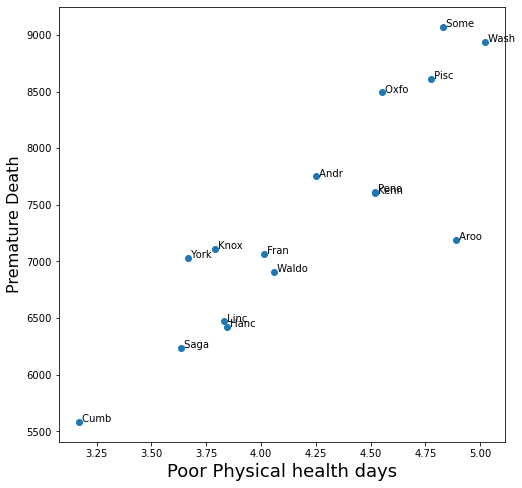

In [123]:
fig, ax = plt.subplots(figsize=(8,8))

# a boolean series gets created with true values for maine counties 
maine_counties = df_sub2.index.isin(maine_fipscode)

x_axis = df_sub2[maine_counties]['v036_rawvalue']
y_axis = df_sub2[maine_counties]['v001_rawvalue']
ax.scatter(x_axis, y_axis)

ax.set_xlabel('Poor Physical health days', fontsize=18)
ax.set_ylabel('Premature Death', fontsize=16)

for i, label in enumerate(maine_county_labels):
    plt.annotate(label, (x_axis.iloc[i], y_axis.iloc[i]))
    
plt.show()

In [124]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
prepared_data = pipeline.fit_transform(df_sub2)
prepared_data_df = pd.DataFrame(prepared_data)
prepared_data_df.index = df_sub2.index
prepared_data_df.columns = df_sub2.columns
prepared_data_df

,v001_rawvalue,v002_rawvalue,v003_rawvalue,v004_rawvalue,v005_rawvalue,v009_rawvalue,v011_rawvalue,v014_rawvalue,v021_rawvalue,v023_rawvalue,...,v148_rawvalue,v153_rawvalue,v154_rawvalue,v155_rawvalue,v156_rawvalue,v159_rawvalue,v160_rawvalue,v161_rawvalue,v166_rawvalue,v168_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,-0.247243,-0.054049,-0.101889,-0.205470,1.182201,-0.364320,-0.075332,-0.313281,0.131797,-0.857910,...,0.135078,0.203832,0.705685,-0.109118,0.004158,0.454784,-0.221560,0.004928,0.584326,0.250498
1003,-0.302948,-0.714412,0.509630,0.461484,-0.653917,-0.676814,-0.577581,-0.141947,-0.024877,-0.859441,...,-0.228653,0.438010,0.075119,0.291640,-0.069242,0.706539,0.189496,0.121032,0.725538,0.616148
1005,1.110815,1.901005,0.659803,-0.621592,0.410558,1.013361,1.297483,0.706552,-0.954114,-0.138927,...,0.899573,-1.280789,0.961944,-0.409686,-0.175616,-2.384825,-3.317797,-1.028510,-1.681706,-2.193532
1007,1.369995,0.730548,-0.032999,-0.011500,1.205304,0.424245,0.661300,0.757900,-0.024877,-0.632443,...,0.767864,0.338645,-0.620675,-0.309497,-0.434748,-1.231696,-1.427522,-0.215645,-0.700148,-1.260174
1009,0.969080,0.365492,0.702493,-0.946490,-0.094244,0.392969,-0.075332,0.257796,0.746833,-0.897957,...,0.938694,0.861341,-0.889766,-0.309497,-0.377639,-0.412154,-0.684242,0.227072,-0.270312,-1.031292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,-0.267719,-0.717821,0.038501,-0.412658,-1.189908,-0.677941,-0.527356,0.106786,-1.235965,-0.073688,...,1.188040,0.555074,-0.717269,-0.109118,0.223189,0.942707,1.480645,1.608381,0.972909,0.932438
56039,-2.053617,-1.701282,0.186108,1.547819,-0.821414,-2.032550,-3.758494,-1.414909,-0.103214,-0.861815,...,-1.172476,-1.339862,-0.110378,0.992966,-0.034947,2.040218,2.126417,-0.621607,1.325967,1.315560
56041,-0.153766,-0.625928,0.144279,-0.134209,-1.018945,-0.134607,0.292984,-0.010478,-0.558547,-0.063613,...,0.937087,0.655035,-1.388798,-0.810444,-0.089693,0.519513,1.240118,1.539990,1.598231,0.925219


In [154]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

In [155]:
maine_counties2 = prepared_data_df.index.isin(maine_fipscode)
maine_df = prepared_data_df[maine_counties2]
maine_df.head()

,v001_rawvalue,v002_rawvalue,v003_rawvalue,v004_rawvalue,v005_rawvalue,v009_rawvalue,v011_rawvalue,v014_rawvalue,v021_rawvalue,v023_rawvalue,...,v148_rawvalue,v153_rawvalue,v154_rawvalue,v155_rawvalue,v156_rawvalue,v159_rawvalue,v160_rawvalue,v161_rawvalue,v166_rawvalue,v168_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
23001,-0.276524,-0.459370,-0.326436,0.949141,-0.764234,0.118601,-0.008365,-0.548345,-1.693213,-0.706137,...,-0.969043,-0.868345,0.005013,0.592208,0.513392,-1.225985,-0.920100,0.072888,0.708239,0.516382
23003,-0.485903,0.310798,0.295198,1.603389,0.467161,0.398114,0.711525,-0.724517,-0.386508,0.406778,...,-0.158839,0.046963,0.049573,-0.610065,-0.390398,0.343229,0.178923,-0.341480,-0.700112,0.259344
23005,-1.084026,-1.637000,-0.657442,3.236529,-1.177202,-1.683310,-1.699271,-1.583720,0.208589,-1.093673,...,-1.453369,-0.277085,0.530293,1.193345,0.691585,1.046272,0.885051,-0.841119,1.338458,1.309698
23007,-0.531495,-0.708643,-0.171613,1.511357,-0.914404,-0.388660,-0.175782,-1.124301,-0.155672,-0.103353,...,0.260409,0.938493,-0.672591,-0.008928,-0.426952,-0.947543,-1.100115,0.164449,0.241160,0.897147
23009,-0.770281,-1.111330,-0.039658,2.516092,-0.727847,-0.725129,-1.130056,-1.004516,-0.248456,-0.321901,...,-0.844090,0.565718,0.280845,0.892776,-0.418584,-0.022461,-0.578311,-0.274594,0.770179,1.136328


In [156]:
y_pred = kmeans.fit_predict(maine_df)
y_pred

array([0, 1, 3, 2, 2, 0, 2, 2, 4, 0, 4, 2, 4, 2, 1, 2])

There is seems to be one large and then a 3 more groups that are fairly small and one group that only ever contains one value.

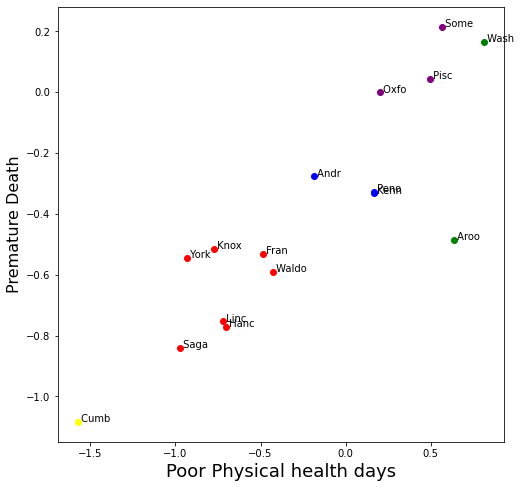

In [157]:
fig, ax = plt.subplots(figsize=(8,8))
colors = ('blue', 'green', 'red', 'yellow', 'purple')


x_axis = maine_df['v036_rawvalue']
y_axis = maine_df['v001_rawvalue']
for i in range(0,5):
    ax.scatter(x=maine_df['v036_rawvalue'][y_pred==i], y=maine_df['v001_rawvalue'][y_pred==i], color=colors[i])

ax.set_xlabel('Poor Physical health days', fontsize=18)
ax.set_ylabel('Premature Death', fontsize=16)

for i, label in enumerate(maine_county_labels):
    plt.annotate(label, (x_axis.iloc[i], y_axis.iloc[i]))
    
plt.show()

In [142]:
inertia = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(maine_df)
  inertia.append(kmeans.inertia_)

inertia

C:\Users\Sage\anaconda3\envs\Project3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[297.7530233570615,
 209.57081669591224,
 171.93229769919137,
 139.5382195439126,
 112.94236382636345,
 91.36092074830786,
 78.03456609617022,
 63.91593393320397,
 55.567522285290885,
 43.255764647564085]

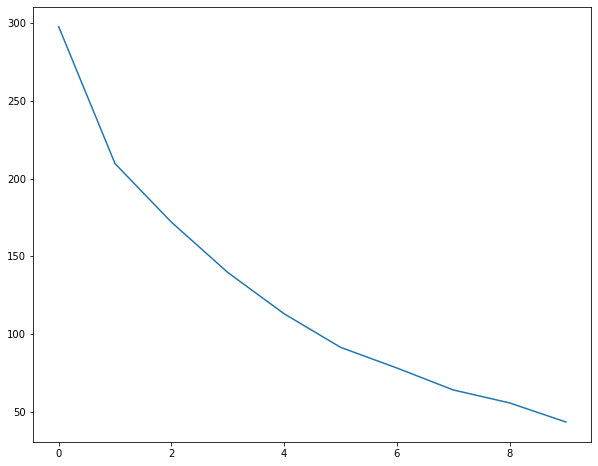

In [147]:
plt.figure(figsize=(10,8))

plt.plot(inertia)

The graph is off by 1 on the x-axis. There seems to be an elbow at 2 clusters, however there looks to be another elbow at 6 clusters. 5 doesn't seem like a bad number of clusters, but there looks like there might be better possibilites.